# Function Goal

This Notebook aims to cluster activites of providers


In [1]:
import sys
print(sys.version)
print(sys.executable)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
/opt/anaconda3/bin/python


# Imports

In [2]:
# import classic libraries
# ------------------------
import pandas as pd
import sys
import os
import pickle
import re
from importlib import reload
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import coo_matrix, hstack

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as TSNE_scikit
# pd.set_option('max_colwidth', 86)

In [3]:
# import custom library
# ------------------------
import os
current_path = os.path.abspath(os.getcwd())
path_lib = current_path.replace('src','')
path_data = current_path.replace('src','data')
sys.path.append(path_lib)

import lib_ar_src
reload(lib_ar_src)
print(lib_ar_src.__version__)

1.0.0


In [4]:
from lib_ar_src.utils.io_utils import importData
from lib_ar_src.clustering.display import plotClusterExample
from lib_ar_src.clustering.display import printCluster
from lib_ar_src.clustering.display import printClusterDistribution
from lib_ar_src.clustering.display import printClusterHomogeneityDistribution
from lib_ar_src.clustering.display import plotClusters
from lib_ar_src.clustering.display import plot_heatmap_dbscan
from lib_ar_src.clustering.display import plot_homog_hdbscan
from lib_ar_src.clustering.display import print_biggestClusters

# Function definition

In [5]:
def html2text(html):
    """
    Remove html tags
    """
    from bs4 import BeautifulSoup
    try:
        soup = BeautifulSoup(html)
        text = soup.get_text()
    except:
        text = html
        
    return text

def intConverter(x):
    ''' robust cast to int '''
    out = -1
    try:
        out = int(x)
    except:
        print('error nan?')
    return out

def floatConverter(x):
    ''' robust cast to int '''
    out = -1
    try:
        out = float(x)
    except:
        print('error nan?')
    return out


def prepare_data_4_clustering(X, df, dict_weight={}, bool_PCA=False, bool_standardization=False):
    """
    preprocess data for clustering
    - normalization by min max
    - PCE (eventual)
    - standardization (eventual)
    """
    
    from sklearn import preprocessing
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    # Normalisation - scaling
    # -----------------------
    scaler = preprocessing.MinMaxScaler().fit(X) # nb with_mean=False obligatoire pour sparse matrix
    Xnorm_raw = scaler.transform(X)
    plt.figure(figsize=(10,10))
    sns.heatmap(Xnorm_raw)
    plt.title('data after scaling')

    # Weighting
    # --------
    list_weights = [] 
    for col in df: # for each column
        default_weight = 1
        for key in dict_weight: # test if belonging to a category
            if (col.find(key) != -1): # if yes
                default_weight = dict_weight[key] # retrieve the appropriate weight
        list_weights.append(default_weight) # append the weight

    Xnorm_weighted = Xnorm_raw
    for col in range(Xnorm_weighted.shape[1]):
        Xnorm_weighted[:,col] = list_weights[col]*Xnorm_weighted[:,col]
    plt.figure(figsize=(10,10))
    sns.heatmap(Xnorm_weighted)
    plt.title('data after weighting')

    # PCA (to keep size under control)
    # ---------------------------------
    if bool_PCA:
        pca = PCA(n_components=100)
        Xnorm = pca.fit_transform(Xnorm_weighted) # conversion from sparse to array is necessary
        print('total explained variance of PCA is : ', sum(pca.explained_variance_ratio_))
        plt.figure(figsize=(10,10))
        sns.heatmap(abs(Xnorm))
        plt.title('data after PCA')
    else:
        Xnorm = Xnorm_weighted


    # Data standardization (eventual)
    # ------------------------------
    if bool_standardization:
        scaler = preprocessing.StandardScaler().fit(Xnorm ) # nb with_mean=False obligatoire pour sparse matrix
        X_total_scaled = scaler.transform(Xnorm)

        plt.figure(figsize=(10,10))
        sns.heatmap(X_total_scaled)
    else:
        X_total_scaled = Xnorm

    # Data used for fitting
    # ---------------------
    x_data = X_total_scaled
    
    return x_data

def create_corpus_from_text_columns(df, col_list):
    """ create a corpus for BAG of word, from specified columns of a df """
    corpus = ''
    for ir in range(df.shape[0]):
        for col in col_list:
            elem = df.loc[ir,col]
            corpus += ' '
            corpus += str(elem)

    # corpus_cleaned
    from lib_ar_src.utils.text_utils import clean_text
    corpus_cleaned = clean_text(corpus)
    corpus_cleaned = re.sub('[0-9]', '', corpus_cleaned)

    return corpus_cleaned

def create_bow(corpus, maxF=100):
    '''
    Create bow model
    '''
    from sklearn.feature_extraction.text import CountVectorizer 
    
    try: # create a list of french and english stopwords
        from nltk.corpus import stopwords    
        final_stopwords_list = stopwords.words('english') \
        + stopwords.words('french') \
        + stopwords.words('german') \
        + stopwords.words('italian')
        
    except:  # if first time, download stopwords list
        import nltk
        nltk.download('stopwords')
        from nltk.corpus import stopwords    
        final_stopwords_list = stopwords.words('english') \
        + stopwords.words('french') \
        + stopwords.words('german') \
        + stopwords.words('italian') 
        
    # create the model
    vectorizer = CountVectorizer(
        max_features=maxF,
        analyzer = 'word',
        stop_words=final_stopwords_list
    )
    bow = vectorizer.fit_transform(corpus)

    return bow, vectorizer


def enrich_with_bow(df, column_name, vectorizer):
    '''
    Enrich a dataframe with bow model applied on a column
    Adds new columns with counts of most common words
    '''
    df_enriched = df.copy()    
    df_bow_mat = vectorizer.transform(df[column_name])
    feature_names = vectorizer.get_feature_names()
    feature_names_formatted = ['bow_'+column_name+'_'+f for f in feature_names]
    df_bow = pd.DataFrame(df_bow_mat.toarray(), columns=feature_names_formatted)   
    df_enriched = pd.concat([df_enriched, df_bow], axis=1)
   
    return df_enriched


def replace_cols_with_bow(df, list_cols_bow, maxF=50):
    """" Replace specified columns by bow  """
    
    df_bow = df.copy()
    
    # force string format
    for col in list_cols_bow:
        df_bow[col] = df_bow[col].apply(lambda x : str(x))
    
    # create a corpus to train BOW    
    corpus_cleaned = create_corpus_from_text_columns(df_bow, list_cols_bow)

    # create bow features
    bow, vectorizer = create_bow([corpus_cleaned], maxF=maxF)
    print('vocabulary used for bow is : ', vectorizer.vocabulary_)

    # add bow features
    for col in list_cols_bow:
        df_bow = enrich_with_bow(df_bow, col, vectorizer)

    # remove textual columns
    from lib_ar_src.utils.df_utils import drop_columns
    df_bow = drop_columns(df_bow, list_cols_bow)
    
    return df_bow

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }   div.cell.selected {border-left-width: 1px !important;} </style>"))

# Import data

In [7]:
!ls ../data

dates.json
events activities.json
extract BK data per location activities.xlsx
extract BK data per location vendors.xlsx
extract BK data per location.xlsx
products.json
vendors.json


In [8]:
# fake or incomplete data
# -----------------------
# df_fake_dates_raw   = importData(os.path.join(path_data, 'dates.json'), 10000)
# df_fake_events_raw   = importData(os.path.join(path_data, 'events activities.json'), 10000)
# df_fake_products_raw   = importData(os.path.join(path_data, 'products.json'), 10000)
# df_fake_vendors_raw   = importData(os.path.join(path_data, 'vendors.json'), 10000)

# complete data (coming from firestore)
# -------------------------------------
df_activities_raw   = importData(os.path.join(path_data, 'extract BK data per location activities.xlsx'), 10000)
df_vendors_raw   = importData(os.path.join(path_data, 'extract BK data per location vendors.xlsx'), 10000)


number of samples : 2354


,id,active,root_event_id,title,description,type,duration,pre_time,max_participants,location,...,images/42,images/43,images/44,tags/3/values/2,tags/3/values/3,country_of_residence,address_pos,city_pos,country_pos,city
0,f9d00ddbf493f6ff340cd77d37660f7a,1,NaN,BRAVO SPORT Fußballcamps - SV 1922 Zwiesel 28....,"<p>Zu cool, um wahr zu sein? Von wegen! Die BR...",BOOKING,720.0,0.0,20,"Rotwaldsiedlung 13, 94227 Zwiesel, Deutschland",...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,34.0,NaN,94227 Zwiesel
1,691d5a6b83ab3aff8561ba691621b97a,1,NaN,ONLINE ESCAPE GAME: AUSGANGSSPERRE,<p><strong>Wir bringen Euch den R&auml;tselspa...,BOOKING,120.0,0.0,1000,@HOME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,@HOME


number of samples : 191


,id,name,url,service_email,service_phone,image,terms,bill_country,country_of_residence,activation_date
0,4379934535e774c3a53b956677f92c0e,Azienda Agricola Bocale di Valentini,https://www.bocale.wine/,info@bocale.it,+390742399233,https://cdn.bookingkit.de/vendor_images/f7a2b2...,<p>In merito alla nostra politica di cancellaz...,IT,IT,2021-01-11T14:55:37Z
1,fe595f13d6bc9618c45f6c3dfc73fd71,Stadtführungen Kassel,https://www.stadtfuehrungen-kassel.de,panetta-moeller@t-online.de,+4956167994,https://cdn.bookingkit.de/vendor_images/934d57...,<p><br />Allgemeine Gesch&auml;ftsbedingungen<...,DE,DE,2021-01-11T14:55:36Z


# Clean data

In [9]:
# for col in df_activities_raw:
#     print(col)

In [10]:
df_activities_clean = df_activities_raw.copy()
df_vendors_clean =  df_vendors_raw.copy()

# clean html into text for activities
html_columns = ['bring', 'advice', 'hint', 'participant_hint', 'title', 'terms', 'description']
# 
for col in html_columns:
    if col in df_activities_clean:
        df_activities_clean[col] = df_activities_clean[col].apply(lambda x : html2text(x))
    if col in df_vendors_clean:
        df_vendors_clean[col] = df_vendors_clean[col].apply(lambda x : html2text(x))

# Merge data

In [11]:
# Display available columns
# -------------------------
# for col in df_activities_raw:
#     print(col)

In [12]:
# merge on vendor id
df_merge = pd.merge(df_activities_clean, df_vendors_clean, left_on=['vendor_id'], right_on = 'id', how='left')
print(df_merge.shape[0])
df_merge = df_merge.fillna(-1)
df_merge=df_merge[df_merge["country_of_residence_y"]=='DE']
df_merge

2354


,id_x,active,root_event_id,title,description,type,duration,pre_time,max_participants,location,...,id_y,name,url,service_email,service_phone,image,terms,bill_country,country_of_residence_y,activation_date
0,f9d00ddbf493f6ff340cd77d37660f7a,1,-1,BRAVO SPORT Fußballcamps - SV 1922 Zwiesel 28....,"Zu cool, um wahr zu sein? Von wegen! Die BRAVO...",BOOKING,720.0,0.0,20,"Rotwaldsiedlung 13, 94227 Zwiesel, Deutschland",...,3b8bcc9344179bdfff454eaadbf03684,erlebnis-buchen.com,erlebnis-buchen.com,noreply@bookingkit.de,030609850332,https://cdn.bookingkit.de/vendor_images/edc56c...,<p>AGB der Demo Inc.</p>,DE,DE,2021-01-06T12:28:50Z
1,691d5a6b83ab3aff8561ba691621b97a,1,-1,ONLINE ESCAPE GAME: AUSGANGSSPERRE,Wir bringen Euch den Rätselspaß nach Hause!\n ...,BOOKING,120.0,0.0,1000,@HOME,...,8c5f7b595bd74eeb915ffa1ae647463a,Dresden Secrets - Escape Games & iPad Rallyes,www.dresden-secrets.de,info@cbikes.de,+4935165318888,https://cdn.bookingkit.de/vendor_images/27b7dc...,"1. Vertragsinhalt Dresden Secrets, Markus Brac...",DE,DE,2021-01-11T14:54:51Z
2,729a82be1e45148c699794fdffefe954,1,-1,ONLINE ESCAPE GAME: LOST CHRISTMAS,Wir bringen Euch den Rätselspaß nach Hause!\nK...,BOOKING,120.0,0.0,1000,@HOME,...,8c5f7b595bd74eeb915ffa1ae647463a,Dresden Secrets - Escape Games & iPad Rallyes,www.dresden-secrets.de,info@cbikes.de,+4935165318888,https://cdn.bookingkit.de/vendor_images/27b7dc...,"1. Vertragsinhalt Dresden Secrets, Markus Brac...",DE,DE,2021-01-11T14:54:51Z
3,c4488666ffceb5de00ec524a45678725,1,-1,Gutschein,"Ob zum Geburtstag, zu Weihnachten, zur Hochzei...",BOOKING,0.0,0.0,1,"Theodor-Heuss-Straße 32, 70174 Stuttgart, Deut...",...,c04d4dcf8618d01cb3ad1c01d5d34e7b,ExitGames Stuttgart,www.exitgames-stuttgart.de,info@exitgames-stuttgart.de,(+49) 0711/18424240,https://cdn.bookingkit.de/vendor_images/bf573f...,AGB,DE,DE,2021-01-11T14:54:25Z
4,98a16d521d47c2f8f09908610fcabd6f,1,-1,ONLINE ESCAPE GAME: DIAMANTENFIEBER,Wir bringen Euch den Rätselspaß nach Hause!\nK...,BOOKING,120.0,0.0,1000,@HOME,...,8c5f7b595bd74eeb915ffa1ae647463a,Dresden Secrets - Escape Games & iPad Rallyes,www.dresden-secrets.de,info@cbikes.de,+4935165318888,https://cdn.bookingkit.de/vendor_images/27b7dc...,"1. Vertragsinhalt Dresden Secrets, Markus Brac...",DE,DE,2021-01-11T14:54:51Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,8335bdc9973ef26681923f632b1b171c,1,-1,Mentoren Training,Lassen Sie sich zum Mentoren Spezialisten ausb...,BOOKING,4320.0,15.0,5,"Hof, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE,DE,2021-01-11T14:55:36Z
2331,55290f6cecd9129b47d15f57c0cc28e2,1,-1,Live Seminar zum Thema - Erfolgreicher Vertrie...,In 4 ausgewählten und erfolgsorientierten Modu...,BOOKING,180.0,600.0,10,"Berlin, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE,DE,2021-01-11T14:55:36Z
2332,596beda6badc3e62973bfa2f762c827c,1,-1,Live Seminar zum Thema - Erfolgreicher Vertrie...,In 4 ausgewählten und erfolgsorientierten Modu...,BOOKING,180.0,600.0,10,"Berlin, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE,DE,2021-01-11T14:55:36Z
2333,858e3a3137fc7b4ad1fa967fafd8dd2e,1,-1,Live Seminar zum Thema - Erfolgreicher Vertrie...,In 4 ausgewählten und erfolgsorientierten Modu...,BOOKING,180.0,600.0,10,"Berlin, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE

# Remarks and insights
- will all those fiels be available with other datasets
- duplicates event id? or because of merge?
- what is pretime?

Features useful :
- title
- location (adress, lon, lat, meeting location)
- adress pos / city pos / country pos
- name or url or service email or phone
- description
- vendor id
- vendor name
- categories/i/title or id

maybe useful
- duration
- bring
- advice
- hint
- participant hint
- highlights/0
- prices




# Encoding

In [13]:
df_merge['description']

0       Zu cool, um wahr zu sein? Von wegen! Die BRAVO...
1       Wir bringen Euch den Rätselspaß nach Hause!\n ...
2       Wir bringen Euch den Rätselspaß nach Hause!\nK...
3       Ob zum Geburtstag, zu Weihnachten, zur Hochzei...
4       Wir bringen Euch den Rätselspaß nach Hause!\nK...
                              ...                        
2330    Lassen Sie sich zum Mentoren Spezialisten ausb...
2331    In 4 ausgewählten und erfolgsorientierten Modu...
2332    In 4 ausgewählten und erfolgsorientierten Modu...
2333    In 4 ausgewählten und erfolgsorientierten Modu...
2334    In 4 ausgewählten und erfolgsorientierten Modu...
Name: description, Length: 1638, dtype: object

In [14]:
# Load the regular expression library
import re

# Remove punctuation
df_merge['description_processed'] = \
df_merge['description'].map(lambda x: re.sub('[,\.!?\n]', '', str(x)))

# Convert the titles to lowercase
df_merge['description_processed'] = \
df_merge['description_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df_merge['description_processed'].head()

0    zu cool um wahr zu sein von wegen die bravo sp...
1    wir bringen euch den rätselspaß nach hause kli...
2    wir bringen euch den rätselspaß nach hauseklic...
3    ob zum geburtstag zu weihnachten zur hochzeit ...
4    wir bringen euch den rätselspaß nach hauseklic...
Name: description_processed, dtype: object

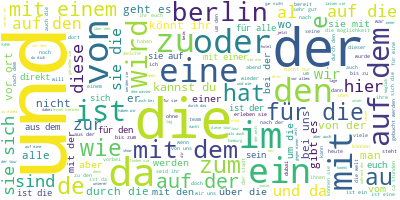

In [15]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_merge['description_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


german_stop_words = stopwords.words('german')

vect = CountVectorizer(stop_words = german_stop_words) # Now use this in your pipeline

In [17]:
def stop_word_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in german_stop_words])


df_merge['description_processed_stop_word']  = df_merge['description_processed'].apply(stop_word_removal)

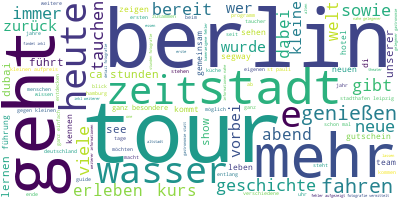

In [18]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_merge['description_processed_stop_word'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Prepare text for LDA analysis 

### Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionar

In [19]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('german')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','the','of','and'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df_merge.description_processed_stop_word.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/idriouich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['cool', 'wahr', 'wegen', 'bravo', 'sport', 'fußballcamps', 'bieten', 'per', 'superstars', 'fußballs', 'hochste', 'zeit', 'know', 'how', 'weiterzugeben', 'trainieren', 'profis', 'lautet', 'motto', 'naturlich', 'gibt', 'fun', 'ende', 'fußball', 'ja', 'schließlich', 'spaß', 'verbinden', 'mega', 'fun']


In [20]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


## LDA model tranining 

In [21]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"boot" + 0.005*"kuche" + 0.005*"mehr" + 0.004*"schon" + 0.004*"dabei" '
  '+ 0.004*"ganz" + 0.004*"mind" + 0.003*"kochkurs" + 0.003*"ol" + '
  '0.003*"neue"'),
 (1,
  '0.012*"tour" + 0.009*"dubai" + 0.007*"geht" + 0.005*"burj" + '
  '0.005*"erleben" + 0.005*"welt" + 0.005*"berlin" + 0.004*"ganz" + '
  '0.004*"zeit" + 0.004*"ab"'),
 (2,
  '0.022*"to" + 0.015*"you" + 0.010*"is" + 0.009*"on" + 0.009*"for" + '
  '0.009*"tour" + 0.008*"with" + 0.007*"city" + 0.007*"at" + 0.007*"berlin"'),
 (3,
  '0.016*"di" + 0.015*"massage" + 0.013*"tour" + 0.008*"il" + 0.008*"bitte" + '
  '0.006*"al" + 0.006*"beachten" + 0.005*"zeit" + 0.005*"un" + 0.004*"la"'),
 (4,
  '0.007*"et" + 0.005*"hamburg" + 0.003*"sit" + 0.003*"unserer" + 0.003*"sed" '
  '+ 0.003*"dolor" + 0.003*"lorem" + 0.003*"ipsum" + 0.003*"diam" + '
  '0.003*"amet"'),
 (5,
  '0.009*"personen" + 0.009*"fotografie" + 0.007*"inkl" + 0.007*"wasser" + '
  '0.007*"stunden" + 0.006*"ca" + 0.005*"mittagspause" + 0.005*"beim" + '
  '0.

### Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:


### Better understanding and interpreting individual topics, and
### Better understanding the relationships between the topics.

### For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

### For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [22]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


###

In [23]:
LDAvis_prepared

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.119256 -0.133559       1        1  18.469655
7      0.064832 -0.191614       2        1  11.717108
9      0.249710  0.133561       3        1  11.246256
0      0.074764 -0.076309       4        1   9.749629
3     -0.080144  0.062834       5        1   9.236051
10     0.016158  0.195871       6        1   8.894996
5      0.031489  0.048570       7        1   8.115791
4     -0.055522 -0.079878       8        1   5.540166
6     -0.089340 -0.035877       9        1   4.964439
2     -0.191048 -0.017391      10        1   4.900520
8     -0.017741  0.014943      11        1   3.744375
11    -0.122414  0.078848      12        1   3.421015, topic_info=          Term        Freq       Total Category  logprob  loglift
967     kannst  289.000000  289.000000  Default  30.0000  30.0000
1950      kurs  311.000000  311.000000  Default  29.0000  29.0000
1747        to  156.000000  156.000000  Default  28.0000  28.0000
289       tour  635.000000  635.000000  Default  27.0000  27.0000
5003   massage  162.000000  162.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
3455     event   12.291963   36.033094  Topic12  -5.7916   2.2997
1947      inkl   12.027187  151.698837  Topic12  -5.8133   0.8405
8255        di   11.988416  223.564321  Topic12  -5.8166   0.4495
2085  komplett   10.052811   24.474675  Topic12  -5.9927   2.4854
1582      nahe   10.368193   64.069363  Topic12  -5.9618   1.5540

[725 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
595       1  0.458054    ab
595       2  0.138960    ab
595       3  0.020587    ab
595       4  0.005147    ab
595       5  0.041173    ab
...     ...       ...   ...
111       6  0.073033  zwei
111       7  0.091292  zwei
111       8  0.012172  zwei
111       9  0.048689  zwei
111      11  0.018258  zwei

[1623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 10, 1, 4, 11, 6, 5, 7, 3, 9, 12])

In [25]:
def Recommend_tags_lda(text, X_train):
    
    ''' Recomendation system for stackoverflow posts based on a lda model, 
    it returns up to 5 tags.
    Parameters:
    text: the stackoverflow post of user
    X_train: data to fit the model with
    '''

    text = clean_text(text)
    text = no_code(text)
    text = clean_punct(text)
    text = stopWordsRemove(text)
    text = lemmatization(text, ['NOUN', 'ADV'])
    n_topics = 10
    threshold = 0.010
    list_scores = []
    list_words = []
    used = set()

    vectorizer_text = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
    vectorizer_text.fit(X_train)
    text_tfidf = vectorizer_text.transform([text])

    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)
    text_projection = lda_model.transform(text_tfidf)
    feature_names = vectorizer_text.get_feature_names()
    lda_components = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(lda_components[topic].argsort()[:-5:-1], sorted(lda_components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    unique_results = [x for x in results if x not in used] # get only unique tags
    tags = " ".join(results[:5])

    return tags


def Recommend_tags_lda_test(X_tfidf_test, X_train):
    
    ''' Recomendation system for stackoverflow posts based on a lda model, 
    it returns up to 5 tags.

    Parameters:

    X_tfidf_test: the stackoverflow posts after TF-IDF transformation
    X_train: data to fit the model with
    '''

    df_tags_test_lda = pd.DataFrame(index=[i for i in range(X_tfidf_test.shape[0])], 
             columns=['0.010', '0.011', '0.012', '0.013'])
    corpus = X_tfidf_test
    n_topics = 10

    vectorizer_text = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
    X_tfidf_train = vectorizer_text.fit_transform(X_train)
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)
    corpus_projection = lda_model.transform(corpus)
    
    feature_names = vectorizer_text.get_feature_names()
    lda_components = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for column, threshold in zip(range(4), [0.010, 0.011, 0.012, 0.013]): #  threshold to exceed to be considered as a relevant tag

        for text in range(corpus.shape[0]):
            list_scores = []
            list_words = []

            for topic in range(n_topics):
                topic_score = corpus_projection[text][topic]

                for (word_idx, word_score) in zip(lda_components[topic].argsort()[:-5:-1], sorted(lda_components[topic])[:-5:-1]):
                    score = topic_score*word_score

                    if score >= threshold:
                        list_scores.append(score)
                        list_words.append(feature_names[word_idx])

            results = [tag for (y,tag) in sorted(zip(list_scores,list_words), 
                                                 key=lambda pair: pair[0], reverse=True)]
            df_tags_test_lda.iloc[text, column] = results[:5] #maximum five tags

    return df_tags_test_lda

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_tags_test_lda = Recommend_tags_lda_test(X_tfidf_test, X_train)


In [28]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


LDAvis_prepared
###

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.014*"kannst" + 0.009*"schon" + 0.009*"naturlich" + 0.009*"kurs" + '
  '0.008*"wetter" + 0.007*"immer" + 0.007*"konnt" + 0.007*"mal" + 0.006*"boot" '
  '+ 0.006*"ganz"'),
 (1,
  '0.010*"dubai" + 0.008*"tour" + 0.006*"burj" + 0.005*"welt" + 0.005*"ganz" + '
  '0.004*"geht" + 0.004*"erleben" + 0.004*"al" + 0.004*"hotel" + '
  '0.003*"berlin"'),
 (2,
  '0.012*"to" + 0.008*"you" + 0.006*"tour" + 0.005*"on" + 0.005*"for" + '
  '0.005*"is" + 0.005*"with" + 0.004*"at" + 0.004*"berlin" + 0.003*"city"'),
 (3,
  '0.013*"di" + 0.009*"massage" + 0.007*"tour" + 0.006*"il" + 0.005*"beachten" '
  '+ 0.005*"kurs" + 0.004*"bitte" + 0.004*"la" + 0.004*"con" + 0.004*"per"'),
 (4,
  '0.004*"heute" + 0.004*"berlin" + 0.004*"stadt" + 0.004*"dabei" + '
  '0.004*"unserer" + 0.004*"leben" + 0.003*"neue" + 0.003*"tour" + '
  '0.003*"hamburg" + 0.003*"zusammen"'),
 (5,
  '0.009*"wasser" + 0.007*"board" + 0.006*"personen" + 0.004*"fotografie" + '
  '0.004*"stunden" + 0.004*"sup" + 0.004*"ca" + 0.004*"ort

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.270278 -0.054952       1        1  20.661010
1      0.003550  0.147185       2        1  19.284257
4      0.012961  0.174329       3        1  16.116524
3      0.073350 -0.149541       4        1  13.427184
5     -0.073579 -0.056754       5        1  12.573941
6      0.090306  0.013303       6        1   9.251267
2      0.163690 -0.073570       7        1   8.685817, topic_info=          Term        Freq       Total Category  logprob  loglift
967     kannst  355.000000  355.000000  Default  30.0000  30.0000
8255        di  211.000000  211.000000  Default  29.0000  29.0000
23006    dubai  217.000000  217.000000  Default  28.0000  28.0000
1747        to  140.000000  140.000000  Default  27.0000  27.0000
5003   massage  147.000000  147.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1947      inkl   22.320131  145.111493   Topic7  -6.1268   0.5715
1803       all   19.494342   56.503922   Topic7  -6.2621   1.3793
1599     preis   19.171930   71.453317   Topic7  -6.2788   1.1279
689        see   19.903742  125.968669   Topic7  -6.2414   0.5984
595         ab   20.331581  189.087034   Topic7  -6.2201   0.2134

[454 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
595       1  0.010577    ab
595       2  0.338468    ab
595       3  0.200966    ab
595       4  0.111060    ab
595       5  0.195677    ab
...     ...       ...   ...
111       2  0.137049  zwei
111       3  0.171311  zwei
111       4  0.068524  zwei
111       5  0.068524  zwei
111       6  0.034262  zwei

[956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 6, 7, 3])